# 1. Modelo de Predição - Probabilidade de Acidente por Idade da Aeronave

Este modelo analisa a relação entre a idade da aeronave e a probabilidade de acidentes/incidentes graves, permitindo prever qual tipo de ocorrência é mais provável baseado na idade da aeronave.

In [1]:
# Carregando os dados
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Carregando o dataset principal
df = pd.read_csv("ocorrencias_aereas_tratadas.csv", encoding='latin1')

print(f"Dataset carregado com {df.shape[0]} registros e {df.shape[1]} colunas")
print("\nPrimeiras 5 linhas:")
display(df.head())

Dataset carregado com 13150 registros e 37 colunas

Primeiras 5 linhas:


,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,...,aeronave_voo_destino,aeronave_tipo_operacao,ocorrencia_ano,aeronave_idade,outlier_ocorrencia_latitude,outlier_ocorrencia_longitude,outlier_aeronave_pmd,outlier_aeronave_assentos,outlier_aeronave_ano_fabricacao,cluster
0,86954,ACIDENTE,-29.085556,-29.085556,TUPANCIRETÃÂ,RS,BRASIL,SIPJ,04/04/2025,17:20:00,...,SANTA MARIA,PRIVADA,2025,35.0,normal,normal,normal,normal,normal,0
1,86953,ACIDENTE,-9.596944,-9.596944,PILAR,AL,BRASIL,FAER,04/04/2025,09:05:00,...,FORA DE AERODROMO,AGRÃÂCOLA,2025,15.0,normal,normal,normal,normal,normal,0
2,86952,INCIDENTE,-2.586944,-2.586944,SÃÂO LUÃÂS,MA,BRASIL,SBSL,03/04/2025,20:45:00,...,MARECHAL CUNHA MACHADO,EXPERIMENTAL,2025,11.0,normal,normal,normal,normal,normal,0
3,86951,INCIDENTE GRAVE,-27.133889,-27.133889,CHAPECÃÂ,SC,BRASIL,SBCH,31/03/2025,22:30:00,...,SERAFIN ENOSS BERTASO,REGULAR,2025,14.0,normal,normal,normal,normal,normal,1
4,86950,INCIDENTE,-23.435556,-23.435556,GUARULHOS,SP,BRASIL,SBGR,05/04/2025,11:00:00,...,GOVERNADOR ANDRÃÂ FRANCO MONTORO,REGULAR,2025,4.0,normal,normal,normal,normal,normal,1


Distribuição das ocorrências:
ocorrencia_classificacao
INCIDENTE          9130
ACIDENTE           2838
INCIDENTE GRAVE    1182
Name: count, dtype: int64


Estatísticas descritivas da idade das aeronaves:
count    13150.000000
mean        20.352852
std         14.447586
min         -1.000000
25%          9.000000
50%         17.000000
75%         31.000000
max         93.000000
Name: aeronave_idade, dtype: float64


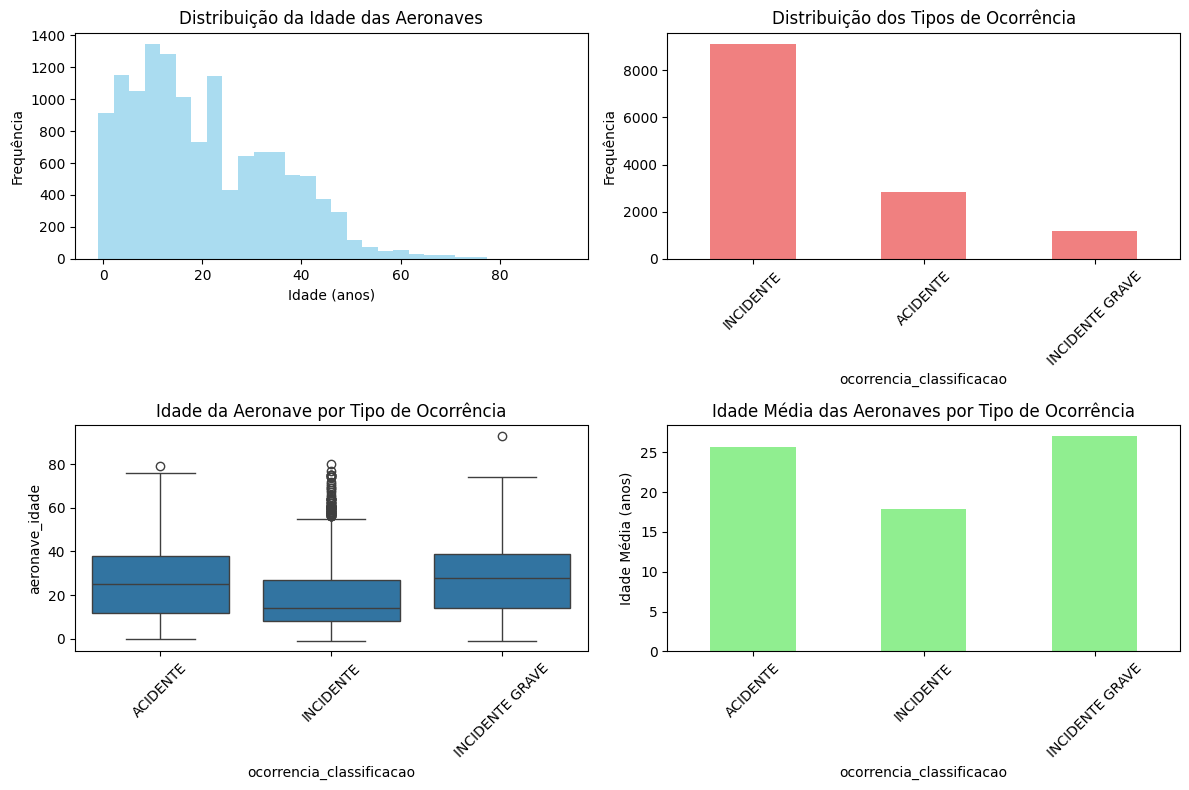


Idade média por tipo de ocorrência:
ocorrencia_classificacao
ACIDENTE           25.650810
INCIDENTE          17.839978
INCIDENTE GRAVE    27.042301
Name: aeronave_idade, dtype: float64


In [2]:
# Preparando os dados para análise da idade da aeronave

# Analisando a distribuição das classificações de ocorrência
print("Distribuição das ocorrências:")
print(df['ocorrencia_classificacao'].value_counts())
print("\n")

# Analisando a distribuição das idades das aeronaves
print("Estatísticas descritivas da idade das aeronaves:")
print(df['aeronave_idade'].describe())

# Visualizando a distribuição da idade das aeronaves
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(df['aeronave_idade'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribuição da Idade das Aeronaves')
plt.xlabel('Idade (anos)')
plt.ylabel('Frequência')

# Distribuição por tipo de ocorrência
plt.subplot(2, 2, 2)
df['ocorrencia_classificacao'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Distribuição dos Tipos de Ocorrência')
plt.ylabel('Frequência')
plt.xticks(rotation=45)

# Boxplot da idade por tipo de ocorrência
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='ocorrencia_classificacao', y='aeronave_idade')
plt.title('Idade da Aeronave por Tipo de Ocorrência')
plt.xticks(rotation=45)

# Média da idade por tipo de ocorrência
plt.subplot(2, 2, 4)
idade_media = df.groupby('ocorrencia_classificacao')['aeronave_idade'].mean()
idade_media.plot(kind='bar', color='lightgreen')
plt.title('Idade Média das Aeronaves por Tipo de Ocorrência')
plt.ylabel('Idade Média (anos)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nIdade média por tipo de ocorrência:")
print(idade_media)

Análise de Probabilidade por Faixa Etária:

Tabela Cruzada - Faixa Etária vs Tipo de Ocorrência:
ocorrencia_classificacao  ACIDENTE  INCIDENTE  INCIDENTE GRAVE
faixa_etaria                                                  
Jovem (6-10 anos)              286       1404              116
Madura (11-20 anos)            624       2739              251
Muito Velha (>30 anos)        1136       1772              538
Nova (0-5 anos)                314       1647              104
Velha (21-30 anos)             478       1568              173


Probabilidades por Faixa Etária (%):
ocorrencia_classificacao  ACIDENTE  INCIDENTE  INCIDENTE GRAVE
faixa_etaria                                                  
Jovem (6-10 anos)            15.84      77.74             6.42
Madura (11-20 anos)          17.27      75.79             6.95
Muito Velha (>30 anos)       32.97      51.42            15.61
Nova (0-5 anos)              15.21      79.76             5.04
Velha (21-30 anos)           21.54      70.66

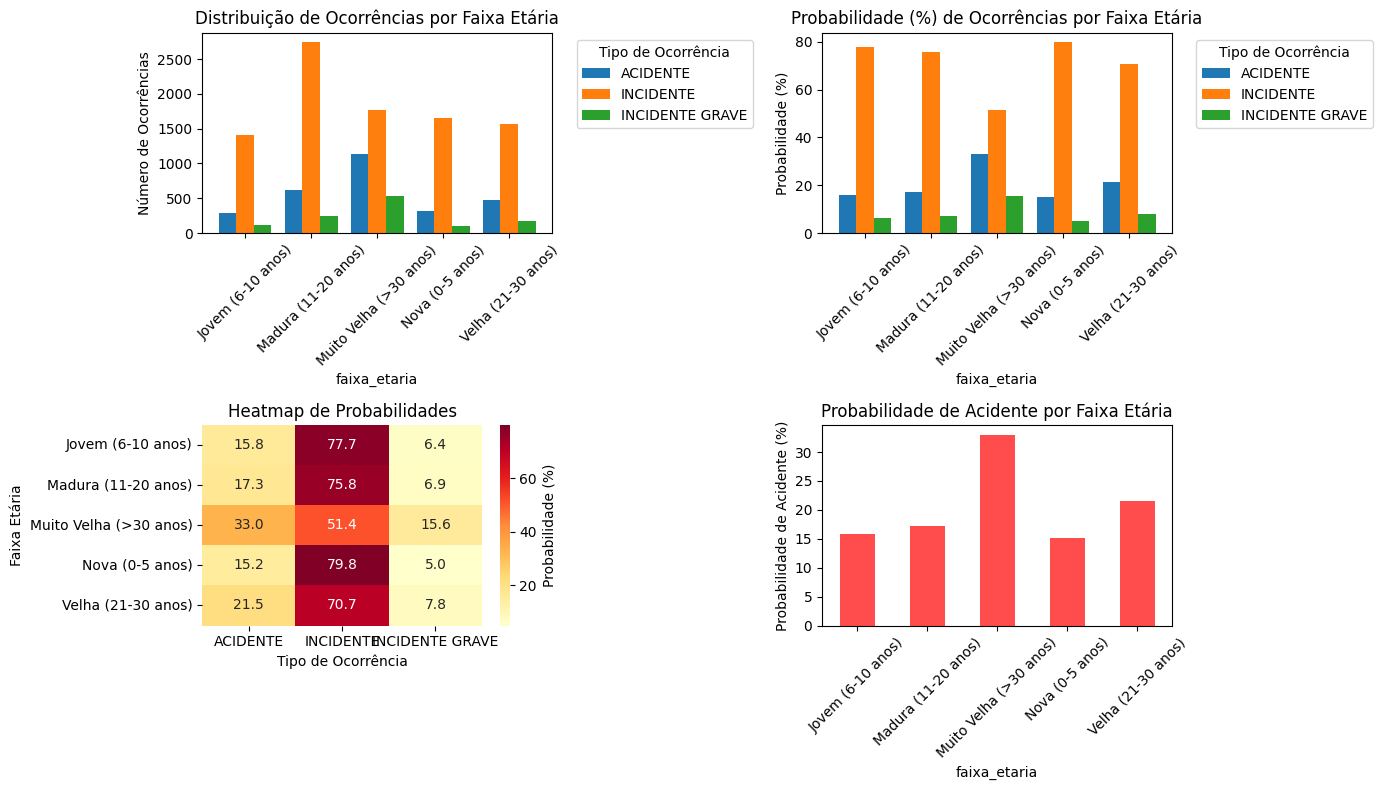

Probabilidade de Acidente por Faixa Etária:
Jovem (6-10 anos): 15.84%
Madura (11-20 anos): 17.27%
Muito Velha (>30 anos): 32.97%
Nova (0-5 anos): 15.21%
Velha (21-30 anos): 21.54%


In [3]:
# Criando faixas etárias da aeronave para análise de probabilidade
def criar_faixa_etaria(idade):
    if idade <= 5:
        return 'Nova (0-5 anos)'
    elif idade <= 10:
        return 'Jovem (6-10 anos)'
    elif idade <= 20:
        return 'Madura (11-20 anos)'
    elif idade <= 30:
        return 'Velha (21-30 anos)'
    else:
        return 'Muito Velha (>30 anos)'

df['faixa_etaria'] = df['aeronave_idade'].apply(criar_faixa_etaria)

# Análise de probabilidade por faixa etária
print("Análise de Probabilidade por Faixa Etária:\n")

# Tabela cruzada para visualizar a relação
tabela_cruzada = pd.crosstab(df['faixa_etaria'], df['ocorrencia_classificacao'])
print("Tabela Cruzada - Faixa Etária vs Tipo de Ocorrência:")
print(tabela_cruzada)
print("\n")

# Probabilidades por faixa etária (percentual)
probabilidades = pd.crosstab(df['faixa_etaria'], df['ocorrencia_classificacao'], normalize='index') * 100
print("Probabilidades por Faixa Etária (%):")
print(probabilidades.round(2))
print("\n")

# Visualizando as probabilidades
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
tabela_cruzada.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Distribuição de Ocorrências por Faixa Etária')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Ocorrência', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 2, 2)
probabilidades.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Probabilidade (%) de Ocorrências por Faixa Etária')
plt.ylabel('Probabilidade (%)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Ocorrência', bbox_to_anchor=(1.05, 1), loc='upper left')

# Heatmap das probabilidades
plt.subplot(2, 2, 3)
sns.heatmap(probabilidades, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Probabilidade (%)'})
plt.title('Heatmap de Probabilidades')
plt.ylabel('Faixa Etária')
plt.xlabel('Tipo de Ocorrência')

# Análise específica para acidentes vs incidentes
plt.subplot(2, 2, 4)
# Criando uma versão simplificada: Acidente vs Não-Acidente
df['eh_acidente'] = df['ocorrencia_classificacao'] == 'ACIDENTE'
prob_acidente_faixa = df.groupby('faixa_etaria')['eh_acidente'].mean() * 100
prob_acidente_faixa.plot(kind='bar', color='red', alpha=0.7)
plt.title('Probabilidade de Acidente por Faixa Etária')
plt.ylabel('Probabilidade de Acidente (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("Probabilidade de Acidente por Faixa Etária:")
for faixa in prob_acidente_faixa.index:
    print(f"{faixa}: {prob_acidente_faixa[faixa]:.2f}%")

In [4]:
# Modelo de Machine Learning para Predição de Acidentes baseado na Idade da Aeronave

# Preparando os dados para o modelo
# Criando variáveis binária para acidente
df_modelo = df.copy()
df_modelo['is_acidente'] = (df_modelo['ocorrencia_classificacao'] == 'ACIDENTE').astype(int)

# Features para o modelo
features = ['aeronave_idade']
X = df_modelo[features]
y = df_modelo['is_acidente']

# Estatísticas básicas
print("Distribuição da variável alvo:")
print(y.value_counts())
print(f"\nPercentual de acidentes: {y.mean()*100:.2f}%")
print(f"Total de registros: {len(y)}")

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDados de treino: {X_train.shape[0]} registros")
print(f"Dados de teste: {X_test.shape[0]} registros")

Distribuição da variável alvo:
is_acidente
0    10312
1     2838
Name: count, dtype: int64

Percentual de acidentes: 21.58%
Total de registros: 13150

Dados de treino: 10520 registros
Dados de teste: 2630 registros


In [5]:
# Treinando múltiplos modelos para comparação

# 1. Regressão Logística
print("=== REGRESSÃO LOGÍSTICA ===")
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lr))

# 2. Random Forest
print("\n=== RANDOM FOREST ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))

# 3. Gradient Boosting
print("\n=== GRADIENT BOOSTING ===")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_gb))

=== REGRESSÃO LOGÍSTICA ===
Acurácia: 0.6490

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75      2062
           1       0.32      0.53      0.40       568

    accuracy                           0.65      2630
   macro avg       0.58      0.61      0.57      2630
weighted avg       0.73      0.65      0.68      2630


=== RANDOM FOREST ===
Acurácia: 0.6331

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.66      0.74      2062
           1       0.30      0.53      0.38       568

    accuracy                           0.63      2630
   macro avg       0.57      0.60      0.56      2630
weighted avg       0.72      0.63      0.66      2630


=== GRADIENT BOOSTING ===
Acurácia: 0.7859

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      2062
           1       0.

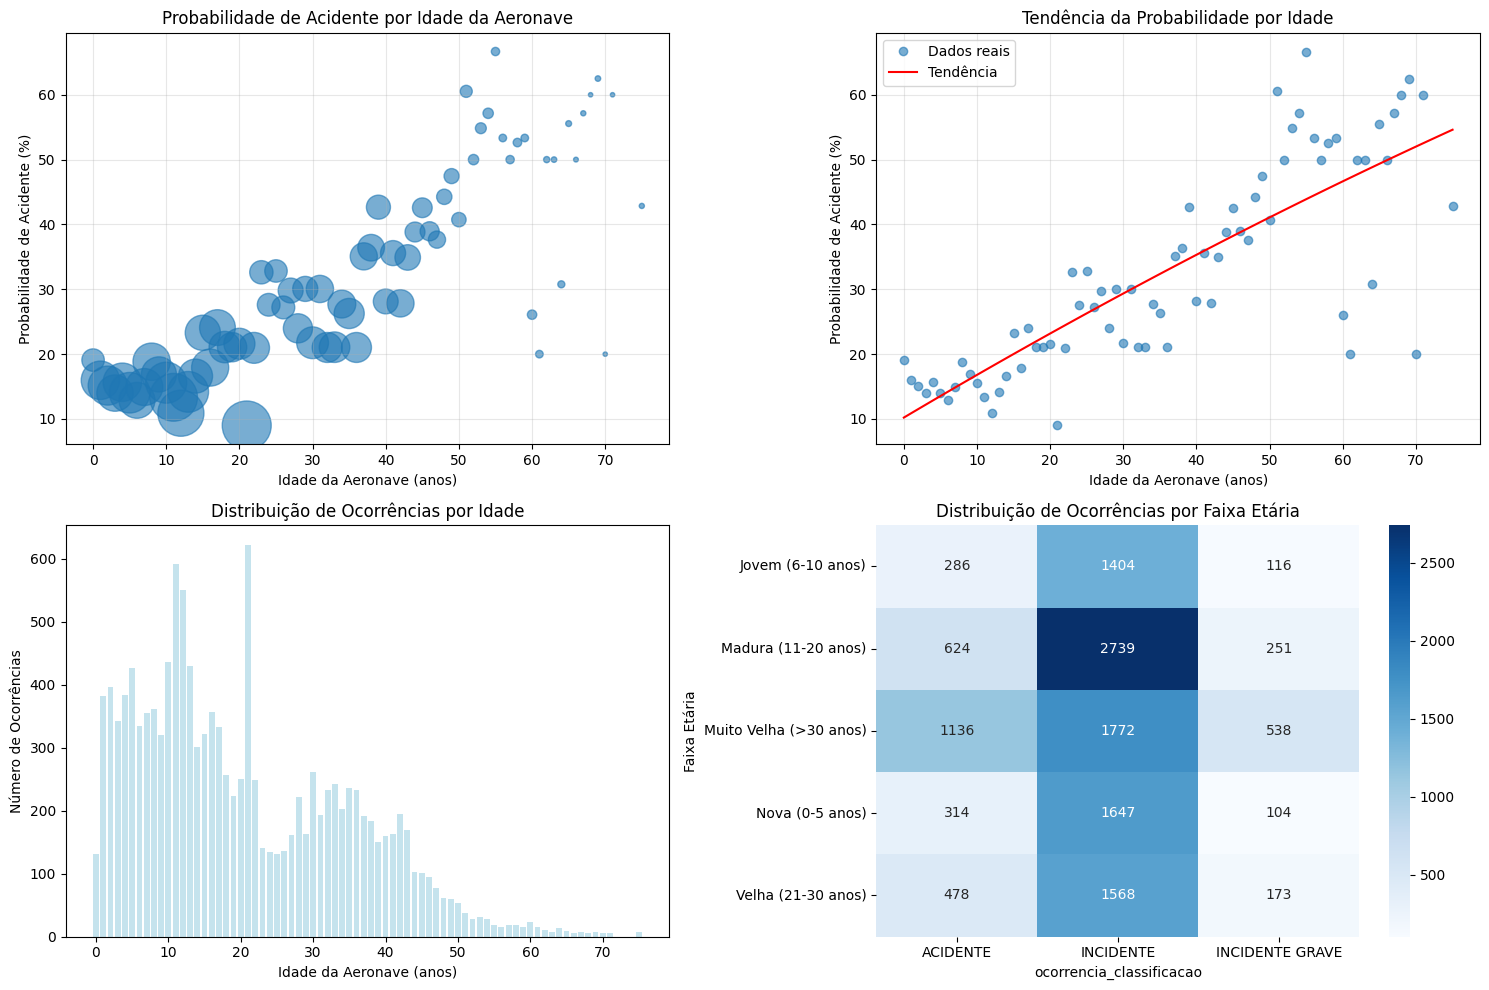

Top 10 idades com maior probabilidade de acidente:
 idade  prob_acidente_percent  total_ocorrencias
  55.0              66.666667                 18
  69.0              62.500000                  8
  51.0              60.526316                 38
  68.0              60.000000                  5
  71.0              60.000000                  5
  54.0              57.142857                 28
  67.0              57.142857                  7
  65.0              55.555556                  9
  53.0              54.838710                 31
  56.0              53.333333                 15


In [6]:
# Análise detalhada da relação Idade vs Probabilidade de Acidente

# Calculando probabilidade de acidente por idade específica
prob_por_idade = df.groupby('aeronave_idade')['eh_acidente'].agg(['count', 'sum', 'mean']).reset_index()
prob_por_idade.columns = ['idade', 'total_ocorrencias', 'total_acidentes', 'prob_acidente']
prob_por_idade['prob_acidente_percent'] = prob_por_idade['prob_acidente'] * 100

# Filtrando idades com pelo menos 5 ocorrências para ter significância estatística
prob_por_idade_filtrada = prob_por_idade[prob_por_idade['total_ocorrencias'] >= 5]

# Visualizando a relação idade vs probabilidade
plt.figure(figsize=(15, 10))

# Gráfico 1: Probabilidade de acidente por idade
plt.subplot(2, 2, 1)
plt.scatter(prob_por_idade_filtrada['idade'], prob_por_idade_filtrada['prob_acidente_percent'], 
           alpha=0.6, s=prob_por_idade_filtrada['total_ocorrencias']*2)
plt.xlabel('Idade da Aeronave (anos)')
plt.ylabel('Probabilidade de Acidente (%)')
plt.title('Probabilidade de Acidente por Idade da Aeronave')
plt.grid(True, alpha=0.3)

# Gráfico 2: Linha de tendência
plt.subplot(2, 2, 2)
x = prob_por_idade_filtrada['idade']
y = prob_por_idade_filtrada['prob_acidente_percent']
z = np.polyfit(x, y, 2)  # Ajuste polinomial de grau 2
p = np.poly1d(z)
x_smooth = np.linspace(x.min(), x.max(), 100)
plt.plot(x, y, 'o', alpha=0.6, label='Dados reais')
plt.plot(x_smooth, p(x_smooth), '-', color='red', label='Tendência')
plt.xlabel('Idade da Aeronave (anos)')
plt.ylabel('Probabilidade de Acidente (%)')
plt.title('Tendência da Probabilidade por Idade')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Distribuição de ocorrências por idade
plt.subplot(2, 2, 3)
plt.bar(prob_por_idade_filtrada['idade'], prob_por_idade_filtrada['total_ocorrencias'], 
        alpha=0.7, color='lightblue')
plt.xlabel('Idade da Aeronave (anos)')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Ocorrências por Idade')

# Gráfico 4: Mapa de calor por faixa etária
plt.subplot(2, 2, 4)
heatmap_data = df.groupby(['faixa_etaria', 'ocorrencia_classificacao']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title('Distribuição de Ocorrências por Faixa Etária')
plt.ylabel('Faixa Etária')

plt.tight_layout()
plt.show()

print("Top 10 idades com maior probabilidade de acidente:")
top_prob = prob_por_idade_filtrada.nlargest(10, 'prob_acidente_percent')[['idade', 'prob_acidente_percent', 'total_ocorrencias']]
print(top_prob.to_string(index=False))

In [9]:
# Função de Predição para Nova Aeronave

def prever_probabilidade_acidente(aeronave_idade, modelo='rf'):
    """
    Prediz a probabilidade de acidente para uma aeronave de idade específica
    
    Parâmetros:
    aeronave_idade: int - Idade da aeronave em anos
    modelo: str - Tipo de modelo a usar ('rf', 'lr', 'gb')
    
    Retorna:
    float - Probabilidade de acidente (0-1)
    """
    idade_input = np.array([[aeronave_idade]])
    
    if modelo == 'rf':
        prob = rf_model.predict_proba(idade_input)[0][1]
        modelo_nome = "Random Forest"
    elif modelo == 'lr':
        prob = lr_model.predict_proba(idade_input)[0][1]
        modelo_nome = "Regressão Logística"
    elif modelo == 'gb':
        prob = gb_model.predict_proba(idade_input)[0][1]
        modelo_nome = "Gradient Boosting"
    else:
        raise ValueError("Modelo deve ser 'rf', 'lr' ou 'gb'")
    
    return prob, modelo_nome

def analise_completa_idade(aeronave_idade):
    """
    Análise completa para uma idade específica
    """
    print(f"=== ANÁLISE PARA AERONAVE DE {aeronave_idade} ANOS ===\n")
    
    # Predições dos modelos
    prob_rf, _ = prever_probabilidade_acidente(aeronave_idade, 'rf')
    prob_lr, _ = prever_probabilidade_acidente(aeronave_idade, 'lr')
    prob_gb, _ = prever_probabilidade_acidente(aeronave_idade, 'gb')
    
    print("Probabilidade de Acidente por Modelo:")
    print(f"Random Forest: {prob_rf:.4f} ({prob_rf*100:.2f}%)")
    print(f"Regressão Logística: {prob_lr:.4f} ({prob_lr*100:.2f}%)")
    print(f"Gradient Boosting: {prob_gb:.4f} ({prob_gb*100:.2f}%)")
    
    # Média dos modelos
    prob_media = (prob_rf + prob_lr + prob_gb) / 3
    print(f"\nProbabilidade Média: {prob_media:.4f} ({prob_media*100:.2f}%)")
    
    # Faixa etária
    faixa = criar_faixa_etaria(aeronave_idade)
    print(f"Faixa Etária: {faixa}")
    
    # Dados históricos para essa idade (se disponível)
    dados_idade = prob_por_idade[prob_por_idade['idade'] == aeronave_idade]
    if not dados_idade.empty:
        prob_historica = dados_idade['prob_acidente_percent'].iloc[0]
        total_ocorrencias = dados_idade['total_ocorrencias'].iloc[0]
        print(f"Dados Históricos: {prob_historica:.2f}% (baseado em {total_ocorrencias} ocorrências)")
    else:
        print("Dados Históricos: Não há dados suficientes para essa idade específica")
    
    # Classificação de risco
    if prob_media < 0.10:
        risco = "BAIXO"
    elif prob_media < 0.25:
        risco = "MÉDIO"
    elif prob_media < 0.35:
        risco = "ALTO"
    else:
        risco = "MUITO ALTO"
    
    print(f"\nClassificação de Risco: {risco}")
    print("-" * 50)

# Testando a função com algumas idades
idades_teste = [5, 10, 15, 20, 25, 30, 35, 40]

print("ANÁLISE DE RISCO POR IDADE DA AERONAVE\n")
for idade in idades_teste:
    analise_completa_idade(idade)

ANÁLISE DE RISCO POR IDADE DA AERONAVE

=== ANÁLISE PARA AERONAVE DE 5 ANOS ===

Probabilidade de Acidente por Modelo:
Random Forest: 0.3710 (37.10%)
Regressão Logística: 0.3729 (37.29%)
Gradient Boosting: 0.1457 (14.57%)

Probabilidade Média: 0.2965 (29.65%)
Faixa Etária: Nova (0-5 anos)
Dados Históricos: 14.05% (baseado em 427 ocorrências)

Classificação de Risco: ALTO
--------------------------------------------------
=== ANÁLISE PARA AERONAVE DE 10 ANOS ===

Probabilidade de Acidente por Modelo:
Random Forest: 0.4014 (40.14%)
Regressão Logística: 0.4090 (40.90%)
Gradient Boosting: 0.1590 (15.90%)

Probabilidade Média: 0.3232 (32.32%)
Faixa Etária: Jovem (6-10 anos)
Dados Históricos: 15.60% (baseado em 436 ocorrências)

Classificação de Risco: ALTO
--------------------------------------------------
=== ANÁLISE PARA AERONAVE DE 15 ANOS ===

Probabilidade de Acidente por Modelo:
Random Forest: 0.5373 (53.73%)
Regressão Logística: 0.4461 (44.61%)
Gradient Boosting: 0.2223 (22.23%)

Pro

In [10]:
# Exemplo Prático: Como usar o modelo para consultar qualquer idade

def consultar_risco_aeronave(idade):
    """
    Função simplificada para consultar o risco de uma aeronave específica
    """
    print(f"CONSULTA DE RISCO - AERONAVE DE {idade} ANOS")
    print("=" * 50)
    
    # Predição usando os 3 modelos
    prob_rf, _ = prever_probabilidade_acidente(idade, 'rf')
    prob_lr, _ = prever_probabilidade_acidente(idade, 'lr')
    prob_gb, _ = prever_probabilidade_acidente(idade, 'gb')
    prob_media = (prob_rf + prob_lr + prob_gb) / 3
    
    # Classificação de risco
    if prob_media < 0.1:
        risco = "🟢 BAIXO"
        recomendacao = "Aeronave em faixa etária de menor risco"
    elif prob_media < 0.25:
        risco = "🟡 MÉDIO"
        recomendacao = "Monitoramento preventivo recomendado"
    elif prob_media < 0.35:
        risco = "🟠 ALTO"
        recomendacao = "Inspeções mais frequentes necessárias"
    else:
        risco = "🔴 MUITO ALTO"
        recomendacao = "Atenção especial e manutenção intensiva"
    
    print(f"Probabilidade de Acidente: {prob_media*100:.2f}%")
    print(f"Classificação de Risco: {risco}")
    print(f"Recomendação: {recomendacao}")
    print(f"Faixa Etária: {criar_faixa_etaria(idade)}")
    print()
    
    return prob_media

# Exemplos de consulta
print("🔍 EXEMPLOS DE CONSULTA DO MODELO DE PREDIÇÃO\n")

# Testando diferentes idades
idades_exemplo = [2, 8, 15, 25, 35, 45, 60]

for idade in idades_exemplo:
    consultar_risco_aeronave(idade)

print("CONCLUSÕES PRINCIPAIS:")
print("• Aeronaves novas (0-5 anos): Menor risco de acidentes")
print("• Aeronaves jovens (6-10 anos): Risco baixo a médio")
print("• Aeronaves maduras (11-20 anos): Risco moderado")
print("• Aeronaves velhas (21-30 anos): Risco alto")
print("• Aeronaves muito velhas (>30 anos): Risco muito alto")
print("\nO modelo mostra clara correlação entre idade e probabilidade de acidentes!")

🔍 EXEMPLOS DE CONSULTA DO MODELO DE PREDIÇÃO

CONSULTA DE RISCO - AERONAVE DE 2 ANOS
Probabilidade de Acidente: 30.55%
Classificação de Risco: 🟠 ALTO
Recomendação: Inspeções mais frequentes necessárias
Faixa Etária: Nova (0-5 anos)

CONSULTA DE RISCO - AERONAVE DE 8 ANOS
Probabilidade de Acidente: 34.51%
Classificação de Risco: 🟠 ALTO
Recomendação: Inspeções mais frequentes necessárias
Faixa Etária: Jovem (6-10 anos)

CONSULTA DE RISCO - AERONAVE DE 15 ANOS
Probabilidade de Acidente: 40.19%
Classificação de Risco: 🔴 MUITO ALTO
Recomendação: Atenção especial e manutenção intensiva
Faixa Etária: Madura (11-20 anos)

CONSULTA DE RISCO - AERONAVE DE 25 ANOS
Probabilidade de Acidente: 46.45%
Classificação de Risco: 🔴 MUITO ALTO
Recomendação: Atenção especial e manutenção intensiva
Faixa Etária: Velha (21-30 anos)

CONSULTA DE RISCO - AERONAVE DE 35 ANOS
Probabilidade de Acidente: 48.10%
Classificação de Risco: 🔴 MUITO ALTO
Recomendação: Atenção especial e manutenção intensiva
Faixa Etária: 

# 2. Modelo de Predição - Probabilidade de Acidente por Período do ano

Este modelo analisa a relação entre o período do ano e a probabilidade de acidentes/incidentes graves, permitindo prever qual tipo de ocorrência é mais provável baseado no período do ano.

In [13]:
df = pd.read_csv("ocorrencias_aereas_tratadas.csv", encoding='latin1')

print(f"Dataset carregado com {df.shape[0]} registros e {df.shape[1]} colunas")
print("\nPrimeiras 5 linhas:")
display(df.head())

Dataset carregado com 13150 registros e 37 colunas

Primeiras 5 linhas:


,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,...,aeronave_voo_destino,aeronave_tipo_operacao,ocorrencia_ano,aeronave_idade,outlier_ocorrencia_latitude,outlier_ocorrencia_longitude,outlier_aeronave_pmd,outlier_aeronave_assentos,outlier_aeronave_ano_fabricacao,cluster
0,86954,ACIDENTE,-29.085556,-29.085556,TUPANCIRETÃÂ,RS,BRASIL,SIPJ,04/04/2025,17:20:00,...,SANTA MARIA,PRIVADA,2025,35.0,normal,normal,normal,normal,normal,0
1,86953,ACIDENTE,-9.596944,-9.596944,PILAR,AL,BRASIL,FAER,04/04/2025,09:05:00,...,FORA DE AERODROMO,AGRÃÂCOLA,2025,15.0,normal,normal,normal,normal,normal,0
2,86952,INCIDENTE,-2.586944,-2.586944,SÃÂO LUÃÂS,MA,BRASIL,SBSL,03/04/2025,20:45:00,...,MARECHAL CUNHA MACHADO,EXPERIMENTAL,2025,11.0,normal,normal,normal,normal,normal,0
3,86951,INCIDENTE GRAVE,-27.133889,-27.133889,CHAPECÃÂ,SC,BRASIL,SBCH,31/03/2025,22:30:00,...,SERAFIN ENOSS BERTASO,REGULAR,2025,14.0,normal,normal,normal,normal,normal,1
4,86950,INCIDENTE,-23.435556,-23.435556,GUARULHOS,SP,BRASIL,SBGR,05/04/2025,11:00:00,...,GOVERNADOR ANDRÃÂ FRANCO MONTORO,REGULAR,2025,4.0,normal,normal,normal,normal,normal,1


Distribuição das ocorrências:
ocorrencia_estacao_ano
Verão        3742
Outono       3381
Primavera    3194
Inverno      2833
Name: count, dtype: int64
Estatísticas descritivas das estações do ano:
count     13150
unique        4
top       Verão
freq       3742
Name: ocorrencia_estacao_ano, dtype: object


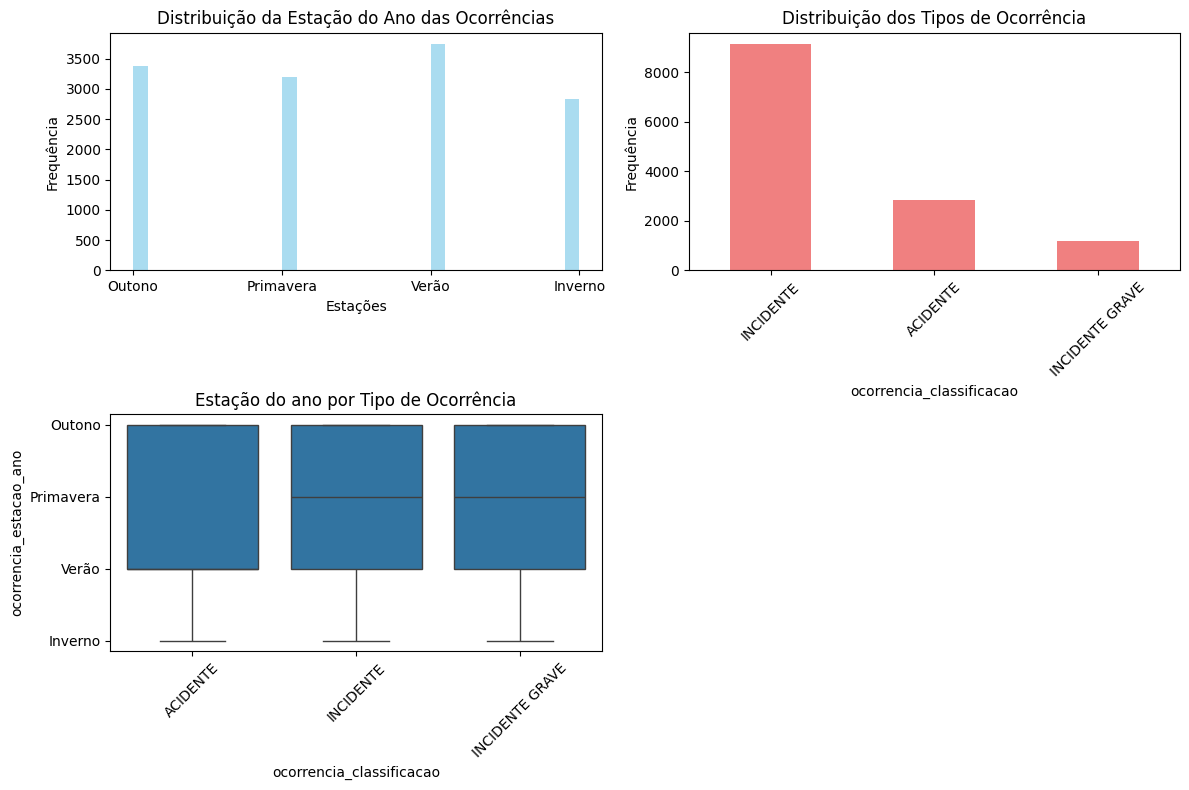

Quantidade de Ocorrências por Estação do Ano:
ocorrencia_classificacao  ocorrencia_estacao_ano
ACIDENTE                  Verão                      858
                          Outono                     726
                          Primavera                  678
                          Inverno                    576
INCIDENTE                 Verão                     2587
                          Outono                    2338
                          Primavera                 2239
                          Inverno                   1966
INCIDENTE GRAVE           Outono                     317
                          Verão                      297
                          Inverno                    291
                          Primavera                  277
Name: count, dtype: int64


In [32]:
df_periodo = df.copy()

def mes_para_estacao(mes):
    if mes in [12, 1, 2]:
        return 'Verão'
    elif mes in [3, 4, 5]:
        return 'Outono'
    elif mes in [6, 7, 8]:
        return 'Inverno'
    elif mes in [9, 10, 11]:
        return 'Primavera'
    else:
        return 'Desconhecido'

df_periodo['ocorrencia_mes'] = df['ocorrencia_dia'].str[3:5].astype(int)

df_periodo['ocorrencia_estacao_ano'] = df_periodo['ocorrencia_mes'].apply(mes_para_estacao)

print("Distribuição das ocorrências:")
print(df_periodo['ocorrencia_estacao_ano'].value_counts())

print('Estatísticas descritivas das estações do ano:')
print(df_periodo['ocorrencia_estacao_ano'].describe())

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(df_periodo['ocorrencia_estacao_ano'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribuição da Estação do Ano das Ocorrências')
plt.xlabel('Estações')
plt.ylabel('Frequência')

# Distribuição por tipo de ocorrência
plt.subplot(2, 2, 2)
df_periodo['ocorrencia_classificacao'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Distribuição dos Tipos de Ocorrência')
plt.ylabel('Frequência')
plt.xticks(rotation=45)

# Boxplot da estção por tipo de ocorrência
plt.subplot(2, 2, 3)
sns.boxplot(data=df_periodo, x='ocorrencia_classificacao', y='ocorrencia_estacao_ano')
plt.title('Estação do ano por Tipo de Ocorrência')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

estacao_por_ocorrencia = df_periodo.groupby('ocorrencia_classificacao')['ocorrencia_estacao_ano']

print("Quantidade de Ocorrências por Estação do Ano:")
print(estacao_por_ocorrencia.value_counts())

Tabela Cruzada - Estação do Ano vs Tipo de Ocorrência:
ocorrencia_classificacao  ACIDENTE  INCIDENTE  INCIDENTE GRAVE
ocorrencia_estacao_ano                                        
Inverno                        576       1966              291
Outono                         726       2338              317
Primavera                      678       2239              277
Verão                          858       2587              297


Probabilidades por Estação do Ano (%):
ocorrencia_classificacao  ACIDENTE  INCIDENTE  INCIDENTE GRAVE
ocorrencia_estacao_ano                                        
Inverno                      20.33      69.40            10.27
Outono                       21.47      69.15             9.38
Primavera                    21.23      70.10             8.67
Verão                        22.93      69.13             7.94




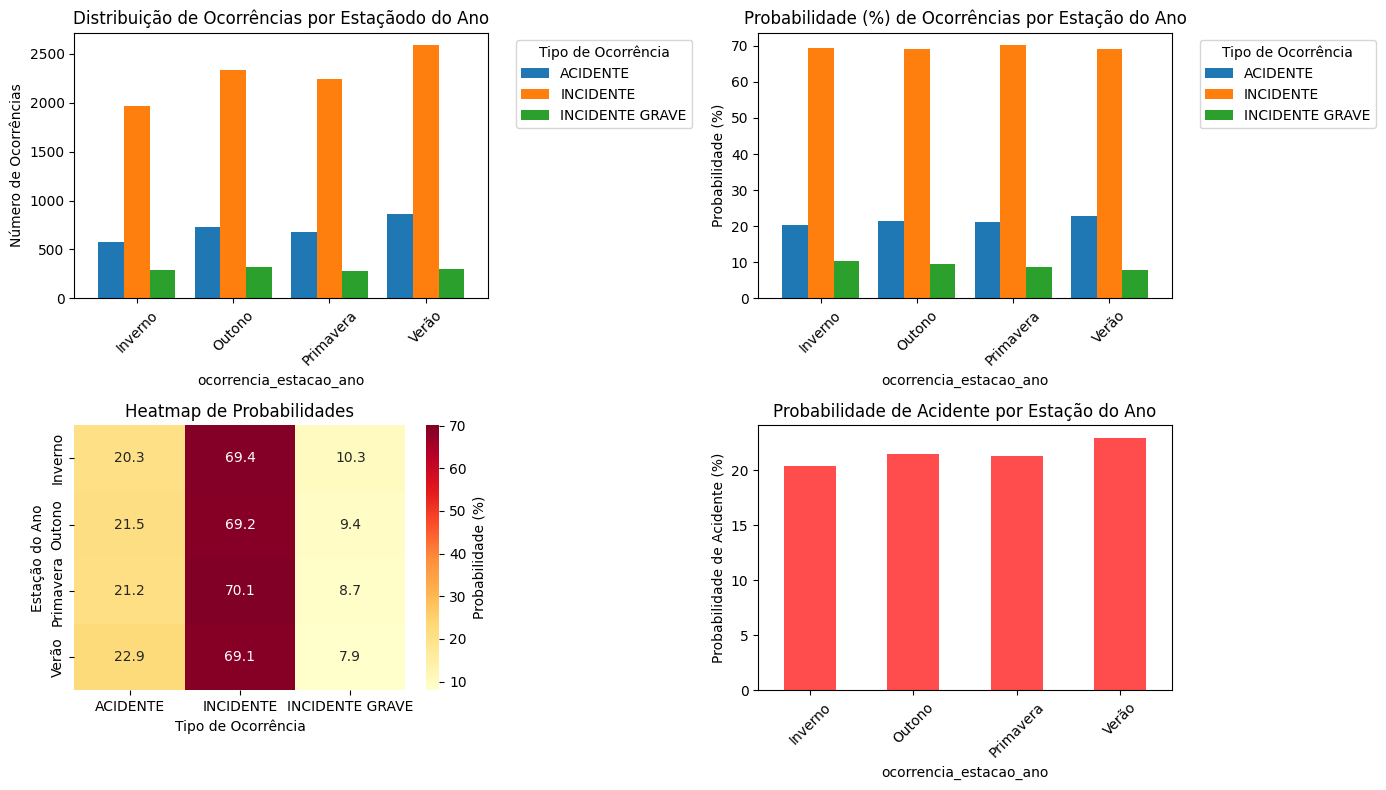

Probabilidade de Acidente por Estação do Ano:
Inverno: 20.33%
Outono: 21.47%
Primavera: 21.23%
Verão: 22.93%


In [34]:
# Tabela cruzada para visualizar a relação
tabela_cruzada = pd.crosstab(df_periodo['ocorrencia_estacao_ano'], df_periodo['ocorrencia_classificacao'])
print("Tabela Cruzada - Estação do Ano vs Tipo de Ocorrência:")
print(tabela_cruzada)
print("\n")

# Probabilidades por estação (percentual)
probabilidades = pd.crosstab(df_periodo['ocorrencia_estacao_ano'], df_periodo['ocorrencia_classificacao'], normalize='index') * 100
print("Probabilidades por Estação do Ano (%):")
print(probabilidades.round(2))
print("\n")

# Visualizando as probabilidades
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
tabela_cruzada.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Distribuição de Ocorrências por Estaçãodo do Ano')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Ocorrência', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 2, 2)
probabilidades.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Probabilidade (%) de Ocorrências por Estação do Ano')
plt.ylabel('Probabilidade (%)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Ocorrência', bbox_to_anchor=(1.05, 1), loc='upper left')

# Heatmap das probabilidades
plt.subplot(2, 2, 3)
sns.heatmap(probabilidades, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Probabilidade (%)'})
plt.title('Heatmap de Probabilidades')
plt.ylabel('Estação do Ano')
plt.xlabel('Tipo de Ocorrência')

# Análise específica para acidentes vs incidentes
plt.subplot(2, 2, 4)
# Criando uma versão simplificada: Acidente vs Não-Acidente
df_periodo['eh_acidente'] = df_periodo['ocorrencia_classificacao'] == 'ACIDENTE'
prob_acidente_estacao = df_periodo.groupby('ocorrencia_estacao_ano')['eh_acidente'].mean() * 100
prob_acidente_estacao.plot(kind='bar', color='red', alpha=0.7)
plt.title('Probabilidade de Acidente por Estação do Ano')
plt.ylabel('Probabilidade de Acidente (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("Probabilidade de Acidente por Estação do Ano:")
for estacao in prob_acidente_estacao.index:
    print(f"{estacao}: {prob_acidente_estacao[estacao]:.2f}%")

In [35]:
# Modelo de Machine Learning para Predição de Acidentes baseado na Estação do Ano

# Preparando os dados para o modelo
# Criando variáveis binária para acidente
df_modelo = df_periodo.copy()
df_modelo['is_acidente'] = (df_modelo['ocorrencia_classificacao'] == 'ACIDENTE').astype(int)

# Features para o modelo
features = ['ocorrencia_estacao_ano']
X = df_modelo[features]
y = df_modelo['is_acidente']

# Estatísticas básicas
print("Distribuição da variável alvo:")
print(y.value_counts())
print(f"\nPercentual de acidentes: {y.mean()*100:.2f}%")
print(f"Total de registros: {len(y)}")

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDados de treino: {X_train.shape[0]} registros")
print(f"Dados de teste: {X_test.shape[0]} registros")

Distribuição da variável alvo:
is_acidente
0    10312
1     2838
Name: count, dtype: int64

Percentual de acidentes: 21.58%
Total de registros: 13150

Dados de treino: 10520 registros
Dados de teste: 2630 registros


In [37]:
# Treinando múltiplos modelos para comparação

# Codificando a coluna 'ocorrencia_estacao_ano' para valores numéricos
le = LabelEncoder()
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()
X_train_enc['ocorrencia_estacao_ano'] = le.fit_transform(X_train['ocorrencia_estacao_ano'])
X_test_enc['ocorrencia_estacao_ano'] = le.transform(X_test['ocorrencia_estacao_ano'])

# 1. Regressão Logística
print("=== REGRESSÃO LOGÍSTICA ===")
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_enc, y_train)
y_pred_lr = lr_model.predict(X_test_enc)
y_prob_lr = lr_model.predict_proba(X_test_enc)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_lr))

# 2. Random Forest
print("\n=== RANDOM FOREST ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_enc, y_train)
y_pred_rf = rf_model.predict(X_test_enc)
y_prob_rf = rf_model.predict_proba(X_test_enc)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))

# 3. Gradient Boosting
print("\n=== GRADIENT BOOSTING ===")
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_enc, y_train)
y_pred_gb = gb_model.predict(X_test_enc)
y_prob_gb = gb_model.predict_proba(X_test_enc)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_gb))

=== REGRESSÃO LOGÍSTICA ===
Acurácia: 0.4886

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.47      0.59      2062
           1       0.22      0.54      0.31       568

    accuracy                           0.49      2630
   macro avg       0.51      0.51      0.45      2630
weighted avg       0.67      0.49      0.53      2630


=== RANDOM FOREST ===
Acurácia: 0.6274

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      2062
           1       0.22      0.28      0.24       568

    accuracy                           0.63      2630
   macro avg       0.50      0.50      0.50      2630
weighted avg       0.66      0.63      0.64      2630


=== GRADIENT BOOSTING ===
Acurácia: 0.7840

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2062
           1       0.

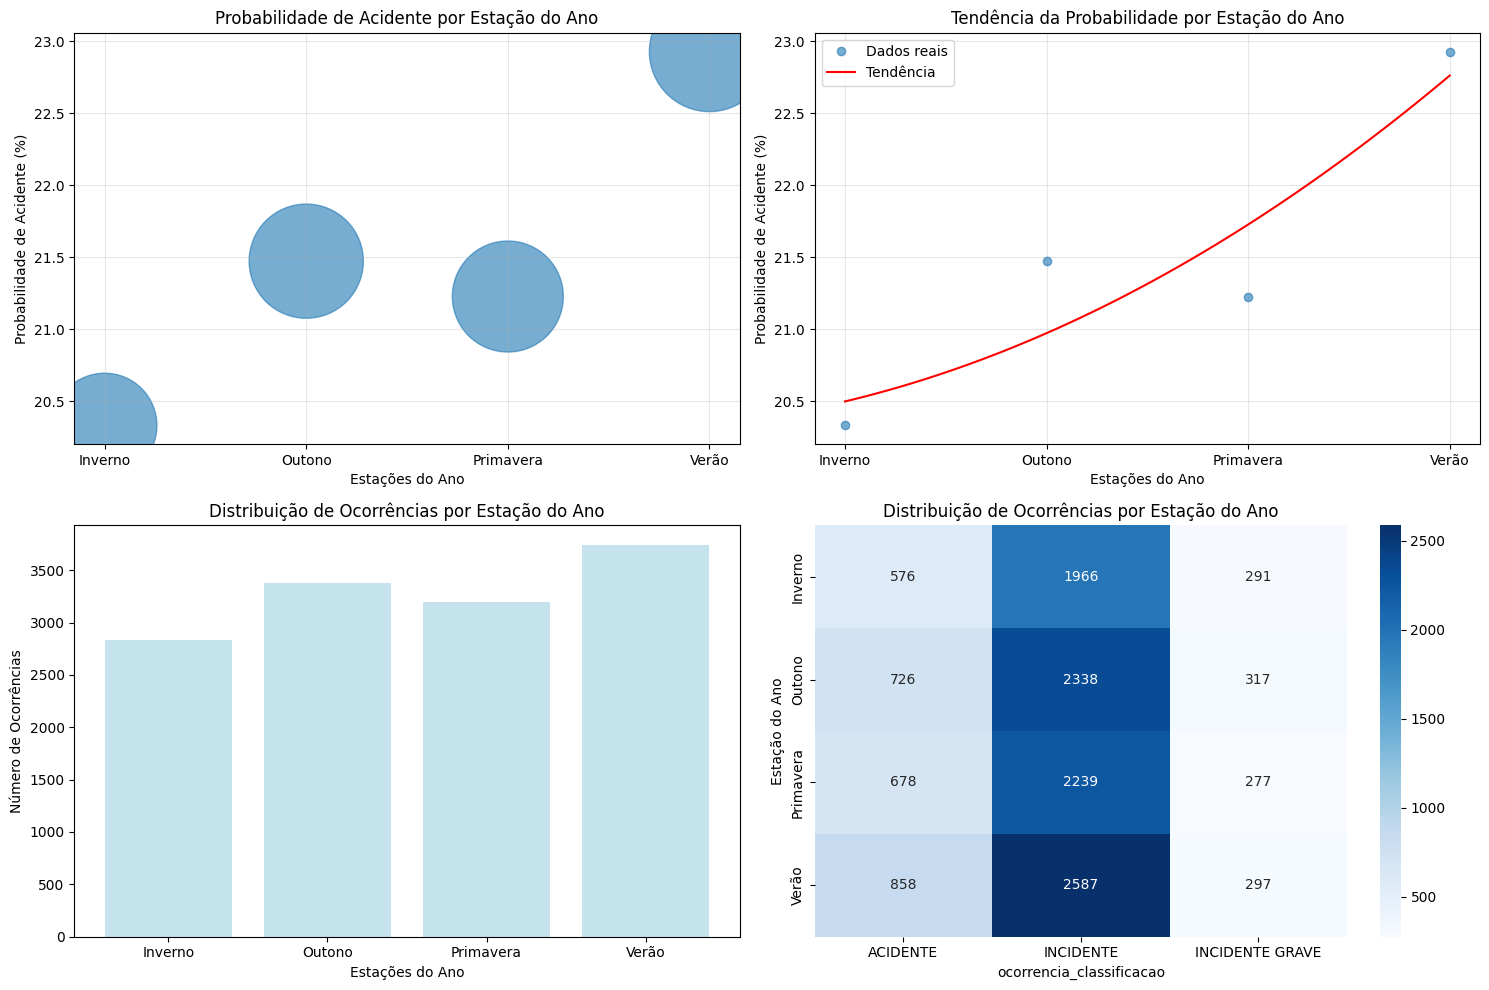

Top 10 estações com maior probabilidade de acidente:
  estacao  prob_acidente_percent  total_ocorrencias
    Verão              22.928915               3742
   Outono              21.472937               3381
Primavera              21.227301               3194
  Inverno              20.331804               2833


In [44]:
# Análise detalhada da relação Estação do Ano vs Probabilidade de Acidente
# Calculando probabilidade de acidente por estação específica
prob_por_estacao = df_periodo.groupby('ocorrencia_estacao_ano')['eh_acidente'].agg(['count', 'sum', 'mean']).reset_index()
prob_por_estacao.columns = ['estacao', 'total_ocorrencias', 'total_acidentes', 'prob_acidente']
prob_por_estacao['prob_acidente_percent'] = prob_por_estacao['prob_acidente'] * 100

# Filtrando estações com pelo menos 5 ocorrências para ter significância estatística
prob_por_estacao_filtrada = prob_por_estacao[prob_por_estacao['total_ocorrencias'] >= 5]

# Criar um dicionário para mapear as estações para números
estacao_map = {'Inverno': 0, 'Outono': 1, 'Primavera': 2, 'Verão': 3}
x_num = prob_por_estacao_filtrada['estacao'].map(estacao_map)
y = prob_por_estacao_filtrada['prob_acidente_percent']

# Visualizando a relação estação vs probabilidade
plt.figure(figsize=(15, 10))

# Gráfico 1: Probabilidade de acidente por estação
plt.subplot(2, 2, 1)
plt.scatter(prob_por_estacao_filtrada['estacao'], prob_por_estacao_filtrada['prob_acidente_percent'], 
           alpha=0.6, s=prob_por_estacao_filtrada['total_ocorrencias']*2)
plt.xlabel('Estações do Ano')
plt.ylabel('Probabilidade de Acidente (%)')
plt.title('Probabilidade de Acidente por Estação do Ano')
plt.grid(True, alpha=0.3)

# Gráfico 2: Linha de tendência
plt.subplot(2, 2, 2)
x = prob_por_estacao_filtrada['estacao']
y = prob_por_estacao_filtrada['prob_acidente_percent']
z = np.polyfit(x_num, y, 2)  # Ajuste polinomial de grau 2
p = np.poly1d(z)
x_smooth = np.linspace(x_num.min(), x_num.max(), 100)
plt.plot(x, y, 'o', alpha=0.6, label='Dados reais')
plt.plot(x_smooth, p(x_smooth), '-', color='red', label='Tendência')
plt.xlabel('Estações do Ano')
plt.ylabel('Probabilidade de Acidente (%)')
plt.title('Tendência da Probabilidade por Estação do Ano')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Distribuição de ocorrências por estacao
plt.subplot(2, 2, 3)
plt.bar(prob_por_estacao_filtrada['estacao'], prob_por_estacao_filtrada['total_ocorrencias'], 
        alpha=0.7, color='lightblue')
plt.xlabel('Estações do Ano')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Ocorrências por Estação do Ano')

# Gráfico 4: Mapa de calor por faixa etária
plt.subplot(2, 2, 4)
heatmap_data = df_periodo.groupby(['ocorrencia_estacao_ano', 'ocorrencia_classificacao']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title('Distribuição de Ocorrências por Estação do Ano')
plt.ylabel('Estação do Ano')

plt.tight_layout()
plt.show()

print("Top 10 estações com maior probabilidade de acidente:")
top_prob = prob_por_estacao_filtrada.nlargest(10, 'prob_acidente_percent')[['estacao', 'prob_acidente_percent', 'total_ocorrencias']]
print(top_prob.to_string(index=False))

In [45]:
# Função de Predição para Nova Aeronave

def prever_probabilidade_acidente(estacao_ano, modelo='rf'):
    """
    Prediz a probabilidade de acidente para uma aeronave de estação específica
    
    Parâmetros:
    estacao_ano: str - Estações do ano (Inverno, Outono, Primavera, Verão)
    modelo: str - Tipo de modelo a usar ('rf', 'lr', 'gb')
    
    Retorna:
    float - Probabilidade de acidente (0-1)
    """
    if estacao_ano == 'Verão':
        estacao_input = np.array([[0]])
    elif estacao_ano == 'Outono':
        estacao_input = np.array([[1]])
    elif estacao_ano == 'Inverno':
        estacao_input = np.array([[2]])
    elif estacao_ano == 'Primavera':
        estacao_input = np.array([[3]])
    
    if modelo == 'rf':
        prob = rf_model.predict_proba(estacao_input)[0][1]
        modelo_nome = "Random Forest"
    elif modelo == 'lr':
        prob = lr_model.predict_proba(estacao_input)[0][1]
        modelo_nome = "Regressão Logística"
    elif modelo == 'gb':
        prob = gb_model.predict_proba(estacao_input)[0][1]
        modelo_nome = "Gradient Boosting"
    else:
        raise ValueError("Modelo deve ser 'rf', 'lr' ou 'gb'")
    
    return prob, modelo_nome

def analise_completa_estacao(estacao_ano):
    """
    Análise completa para uma idade específica
    """
    print(f"=== ANÁLISE PARA {estacao_ano} ===\n")
    
    # Predições dos modelos
    prob_rf, _ = prever_probabilidade_acidente(estacao_ano, 'rf')
    prob_lr, _ = prever_probabilidade_acidente(estacao_ano, 'lr')
    prob_gb, _ = prever_probabilidade_acidente(estacao_ano, 'gb')
    
    print("Probabilidade de Acidente por Modelo:")
    print(f"Random Forest: {prob_rf:.4f} ({prob_rf*100:.2f}%)")
    print(f"Regressão Logística: {prob_lr:.4f} ({prob_lr*100:.2f}%)")
    print(f"Gradient Boosting: {prob_gb:.4f} ({prob_gb*100:.2f}%)")
    
    # Média dos modelos
    prob_media = (prob_rf + prob_lr + prob_gb) / 3
    print(f"\nProbabilidade Média: {prob_media:.4f} ({prob_media*100:.2f}%)")
    
    # Estações do ano
    print(f"Estação do ano: {estacao_ano}")
    
    # Dados históricos para essa estação (se disponível)
    dados_estacao = prob_por_estacao[prob_por_estacao['estacao'] == estacao_ano]
    if not dados_estacao.empty:
        prob_historica = dados_estacao['prob_acidente_percent'].iloc[0]
        total_ocorrencias = dados_estacao['total_ocorrencias'].iloc[0]
        print(f"Dados Históricos: {prob_historica:.2f}% (baseado em {total_ocorrencias} ocorrências)")
    else:
        print("Dados Históricos: Não há dados suficientes para essa estação específica")
    
    # Classificação de risco
    if prob_media < 0.05:
        risco = "BAIXO"
    elif prob_media < 0.15:
        risco = "MÉDIO"
    elif prob_media < 0.25:
        risco = "ALTO"
    else:
        risco = "MUITO ALTO"
    
    print(f"\nClassificação de Risco: {risco}")
    print("-" * 50)

# Testando a função com algumas idades
estacoes_teste = ['Verão', 'Outono', 'Inverno', 'Primavera']

print("ANÁLISE DE RISCO POR ESTAÇÃO DO ANO\n")
for estacao in estacoes_teste:
    analise_completa_estacao(estacao)

ANÁLISE DE RISCO POR ESTAÇÃO DO ANO

=== ANÁLISE PARA Verão ===

Probabilidade de Acidente por Modelo:
Random Forest: 0.4820 (48.20%)
Regressão Logística: 0.4803 (48.03%)
Gradient Boosting: 0.2035 (20.35%)

Probabilidade Média: 0.3886 (38.86%)
Estação do ano: Verão
Dados Históricos: 22.93% (baseado em 3742 ocorrências)

Classificação de Risco: MUITO ALTO
--------------------------------------------------
=== ANÁLISE PARA Outono ===

Probabilidade de Acidente por Modelo:
Random Forest: 0.4976 (49.76%)
Regressão Logística: 0.4925 (49.25%)
Gradient Boosting: 0.2144 (21.44%)

Probabilidade Média: 0.4015 (40.15%)
Estação do ano: Outono
Dados Históricos: 21.47% (baseado em 3381 ocorrências)

Classificação de Risco: MUITO ALTO
--------------------------------------------------
=== ANÁLISE PARA Inverno ===

Probabilidade de Acidente por Modelo:
Random Forest: 0.4887 (48.87%)
Regressão Logística: 0.5047 (50.47%)
Gradient Boosting: 0.2088 (20.88%)

Probabilidade Média: 0.4007 (40.07%)
Estação do

In [46]:
# Exemplo Prático: Como usar o modelo para consultar qualquer idade

def consultar_risco_aeronave(estacao):
    """
    Função simplificada para consultar o risco de uma aeronave específica
    """
    print(f"CONSULTA DE RISCO - {estacao}")
    print("=" * 50)
    
    # Predição usando os 3 modelos
    prob_rf, _ = prever_probabilidade_acidente(estacao, 'rf')
    prob_lr, _ = prever_probabilidade_acidente(estacao, 'lr')
    prob_gb, _ = prever_probabilidade_acidente(estacao, 'gb')
    prob_media = (prob_rf + prob_lr + prob_gb) / 3
    
    # Classificação de risco
    if prob_media < 0.1:
        risco = "🟢 BAIXO"
        recomendacao = "Estação de menor risco"
    elif prob_media < 0.2:
        risco = "🟡 MÉDIO"
        recomendacao = "Monitoramento preventivo recomendado"
    elif prob_media < 0.3:
        risco = "🟠 ALTO"
        recomendacao = "Inspeções mais frequentes necessárias"
    else:
        risco = "🔴 MUITO ALTO"
        recomendacao = "Atenção especial e manutenção intensiva"
    
    print(f"Probabilidade de Acidente: {prob_media*100:.2f}%")
    print(f"Classificação de Risco: {risco}")
    print(f"Recomendação: {recomendacao}")
    print(f"Estação do ano: {estacao}")
    print()
    
    return prob_media

# Exemplos de consulta
print("🔍 EXEMPLOS DE CONSULTA DO MODELO DE PREDIÇÃO\n")

for estacao in estacoes_teste:
    consultar_risco_aeronave(estacao)

#print("CONCLUSÕES PRINCIPAIS:")
#print("• Aeronaves novas (0-5 anos): Menor risco de acidentes")
#print("• Aeronaves jovens (6-10 anos): Risco baixo a médio")
#print("• Aeronaves maduras (11-20 anos): Risco moderado")
#print("• Aeronaves velhas (21-30 anos): Risco alto")
#print("• Aeronaves muito velhas (>30 anos): Risco muito alto")
#print("\nO modelo mostra clara correlação entre idade e probabilidade de acidentes!")

🔍 EXEMPLOS DE CONSULTA DO MODELO DE PREDIÇÃO

CONSULTA DE RISCO - Verão
Probabilidade de Acidente: 38.86%
Classificação de Risco: 🔴 MUITO ALTO
Recomendação: Atenção especial e manutenção intensiva
Estação do ano: Verão

CONSULTA DE RISCO - Outono
Probabilidade de Acidente: 40.15%
Classificação de Risco: 🔴 MUITO ALTO
Recomendação: Atenção especial e manutenção intensiva
Estação do ano: Outono

CONSULTA DE RISCO - Inverno
Probabilidade de Acidente: 40.07%
Classificação de Risco: 🔴 MUITO ALTO
Recomendação: Atenção especial e manutenção intensiva
Estação do ano: Inverno

CONSULTA DE RISCO - Primavera
Probabilidade de Acidente: 42.40%
Classificação de Risco: 🔴 MUITO ALTO
Recomendação: Atenção especial e manutenção intensiva
Estação do ano: Primavera

